# Creating hurricane tracks using Geoanalytics

The sample code below uses big data analytics (GeoAnalytics) to reconstruct hurricane tracks using data registered on a big data file share in the GIS. Note that this functionality is currently available on ArcGIS Enterprise 10.5 and not yet with ArcGIS Online.

## Reconstruct tracks
Reconstruct tracks is a type of data aggregation tool available in the `arcgis.geoanalytics` module. This tool works with a layer of point features or polygon features that are time enabled. It first determines which points belong to a track using an identification number or identification string. Using the time at each location, the tracks are ordered sequentially and transformed into a line representing the path of movement.

## Data used
For this sample, hurricane data from over a period of 50 years, totalling about 150,000 points split into 5 shape files was used. The [National Hurricane Center](http://www.nhc.noaa.gov/gis/) provides similar datasets that can be used for exploratory purposes.

To illustrate the nature of the data a subset was published as a feature service and can be visualized as below:

In [1]:
from arcgis.gis import GIS

#Let us connect to an ArcGIS Enterprise
gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')
hurricane_pts = gis.content.get('ebdb876ca1a74cc89a81c3f8ee481e94')
hurricane_pts

<Item title:"Hurricane_tracks_points" type:Feature Layer Collection owner:arcgis_python>

In [2]:
subset_map = gis.map("USA")
subset_map

MapView(layout=Layout(height='400px', width='100%'))

In [3]:
subset_map.add_layer(hurricane_pts)

## Inspect the data attributes
Let us query the first layer in hurricane_pts and view its attribute table as a Pandas dataframe.

In [4]:
hurricane_pts.layers[0].query(as_df=True).head()

,serial_num,season,num,basin,sub_basin,name,iso_time,nature,latitude,longitude,...,center,wind_wmo1,pres_wmo1,track_type,size,Wind,INSTANT_DATETIME,globalid,OBJECTID,SHAPE
0,1927265N10325,1927,3,NA,MM,NOT NAMED,9/26/1927 0:00,TS,16.8,-43.6,...,atcf,32.263,-100.000,main,35000,35000,1927-09-26 00:00:00,{2360A7E6-07CE-C8E9-B05C-1BE4CC0466AC},1,"{""x"": -43.6, ""y"": 16.8, ""spatialReference"": {""..."
1,1978347S20041,1979,2,SI,MM,02S:ANGELE,12/24/1978 12:00,NR,-22.0,36.4,...,reunion,-100.000,-100.000,main,0,0,1978-12-24 12:00:00,{5263FA06-0416-E055-F3A2-7CF1F9F3CD21},2,"{""x"": 36.4, ""y"": -22, ""spatialReference"": {""wk..."
2,1994362S11054,1995,4,SI,MM,CHRISTELLE,12/31/1994 0:00,TS,-13.8,51.9,...,reunion,15.938,16.458,main,25000,25000,1994-12-31 00:00:00,{357134CE-40B1-75F9-C82C-5DE32098E161},3,"{""x"": 51.9, ""y"": -13.8, ""spatialReference"": {""..."
3,2006093S15115,2006,14,SI,WA,HUBERT,4/3/2006 12:00,NR,-14.4,114.4,...,bom,8.490,23.063,main,25300,25300,2006-04-03 12:00:00,{4BA29993-3C4B-831A-AC79-4E940FD4D00D},4,"{""x"": 114.4, ""y"": -14.4, ""spatialReference"": {..."
4,1951009S16140,1951,3,SP,EA,09P,1/23/1951 23:00,NR,-21.9,143.0,...,bom,-100.000,4.181,main,0,0,1951-01-23 23:00:00,{4BB38CC9-7C65-EDEB-9CE8-61CA9D948743},5,"{""x"": 143, ""y"": -21.9, ""spatialReference"": {""w..."


## Create a data store
For the GeoAnalytics server to process your big data, it needs the data to be registered as a data store. In our case, the data is in multiple shape files and we will register the folder containing the files as a data store of type `bigDataFileShare`.

Let us connect to an ArcGIS Enterprise

In [5]:
gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

Get the geoanalytics datastores and search it for the registered datasets:

In [16]:
# Query the data stores available
import arcgis
datastores = arcgis.geoanalytics.get_datastores()

bigdata_fileshares = datastores.search(id='a215eebc-1bab-42d5-9aa0-45fe2549ba55')
bigdata_fileshares

[<Datastore title:"/bigDataFileShares/all_hurricanes" type:"bigDataFileShare">]

The dataset `hurricanes_all` data is registered as a big data file share with the Geoanalytics datastore, so we can reference it:

In [17]:
data_item = bigdata_fileshares[0]

If there is no big data file share for hurricane track data registered on the server, we can register one that points to the shared folder containing the shape files.

In [8]:
# data_item = datastores.add_bigdata("Hurricane_tracks", r"\\path_to_hurricane_data")

Once a big data file share is registered, the GeoAnalytics server processes all the valid file types to discern the schema of the data, including information about the geometry in a dataset. If the dataset is time-enabled, as is required to use some GeoAnalytics Tools, the manifest reports the necessary metadata about how time information is stored as well.

This process can take a few minutes depending on the size of your data. Once processed, querying the manifest property returns the schema. As you can see from below, the schema is similar to the subset we observed earlier in this sample.

In [9]:
data_item.manifest['datasets'][0] #for brevity only a portion is printed

{'name': 'hurricanes',
 'format': {'type': 'shapefile', 'extension': 'shp'},
 'schema': {'fields': [{'name': 'serial_num', 'type': 'esriFieldTypeString'},
   {'name': 'season', 'type': 'esriFieldTypeBigInteger'},
   {'name': 'num', 'type': 'esriFieldTypeBigInteger'},
   {'name': 'basin', 'type': 'esriFieldTypeString'},
   {'name': 'sub_basin', 'type': 'esriFieldTypeString'},
   {'name': 'name', 'type': 'esriFieldTypeString'},
   {'name': 'iso_time', 'type': 'esriFieldTypeString'},
   {'name': 'nature', 'type': 'esriFieldTypeString'},
   {'name': 'latitude', 'type': 'esriFieldTypeDouble'},
   {'name': 'longitude', 'type': 'esriFieldTypeDouble'},
   {'name': 'wind_wmo_', 'type': 'esriFieldTypeDouble'},
   {'name': 'pres_wmo_', 'type': 'esriFieldTypeBigInteger'},
   {'name': 'center', 'type': 'esriFieldTypeString'},
   {'name': 'wind_wmo1', 'type': 'esriFieldTypeDouble'},
   {'name': 'pres_wmo1', 'type': 'esriFieldTypeDouble'},
   {'name': 'track_type', 'type': 'esriFieldTypeString'},
   

## Perform data aggregation using reconstruct tracks tool

When you add a big data file share, a corresponding item gets created in your GIS. You can search for it like a regular item and query its layers.

In [10]:
search_result = gis.content.search("bigDataFileShares_hurricanes_all", item_type = "big data file share")
search_result

[<Item title:"bigDataFileShares_all_hurricanes" type:Big Data File Share owner:api_data_owner>]

In [11]:
data_item = search_result[0]
data_item

<Item title:"bigDataFileShares_all_hurricanes" type:Big Data File Share owner:api_data_owner>

In [12]:
years_50 = data_item.layers[0]
years_50

<Layer url:"https://pythonapi.playground.esri.com/ga/rest/services/DataStoreCatalogs/bigDataFileShares_all_hurricanes/BigDataCatalogServer/hurricanes">

### Reconstruct tracks tool

The `reconstruct_tracks()` function is available in the `arcgis.geoanalytics.summarize_data` module. In this example, we are using this tool to aggregate the numerous points into line segments showing the tracks followed by the hurricanes. The tool creates a feature layer item as an output which can be accessed once the processing is complete.

In [13]:
from arcgis.geoanalytics.summarize_data import reconstruct_tracks
from datetime import datetime as dt

In [14]:
agg_result = reconstruct_tracks(years_50, 
                                track_fields='Serial_Num',
                                output_name='construct tracks test' + str(dt.now().microsecond))

TypeError: submit() missing 1 required positional argument: 'fn'

## Inspect the results
Let us create a map and load the processed result which is a feature service


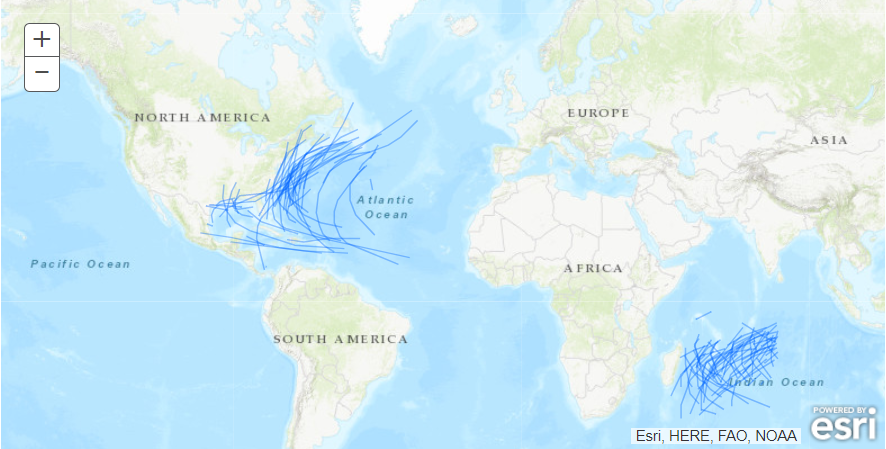

In [2]:
processed_map = gis.map("USA")
processed_map

In [15]:
processed_map.add_layer(agg_result)

Thus we transformed a bunch of ponints into tracks that represents paths taken by the hurricanes over a period of 50 years. We can pull up another map and inspect the results a bit more closely

Our input data and the map widget is time enabled. Thus we can filter the data to represent the tracks from only the years 1860 to 1870

In [16]:
processed_map.set_time_extent('1860', '1870')

## What can geoanalytics do for you?

With this sample we just scratched the surface of what big data analysis can do for you. ArcGIS Enterprise at 10.5 packs a powerful set of tools that let you derive a lot of value from your data. You can do so by asking the right questions, for instance, a weather dataset such as this could be used to answer a few interesting questions such as
 
 - did the number of hurricanes per season increase over the years?
 - give me the hurricanes that travelled longest distance
 - give me the ones that stayed for longest time. Do we see a trend?
 - how are wind speed and distance travelled correlated?
 - my assets are located in a tornado corridor. How many times in the past century, was there a hurricane within 50 miles from my assets?
 - my industry is dependent on tourism, which is heavily impacted by the vagaries of weather. From historical weather data, can I correlate my profits with major weather events? How well is my business insulated from freak weather events?
 - over the years do we see any shifts in major weather events - do we notice a shift in when the hurricane season starts?
 
The ArcGIS API for Python gives you a gateway to easily access the big data tools from your ArcGIS Enterprise. By combining it with other powerful libraries from the pandas and scipy stack and the rich visualization capabilities of the Jupyter notebook, you can extract a lot of value from your data, big or small.